A friend of mine introduced me to a long running series of puzzles called "the riddler" that are put out by 538 once a week. The harder "riddler classic" this week was interesting enough that I decided to give it a try. The code I wrote while messing around with the riddle was interesting enough that I thought I would share.

<!-- TEASER_END -->

https://fivethirtyeight.com/features/what-are-the-odds-world-cup-teams-play-each-other-twice/

Here is the text of the riddle for convenience,

>Riddler Classic

>From Jan-Willem Tel, a puzzle of efficient breaking and entering:

>You have a gate that requires a passcode to open. There are 10 buttons: the digits 0 to 9. You have forgotten the passcode, but you remember it has four digits. You have no choice but to try them all.

>Since there are 10^4 = 10,000 four-digit passcodes, you might think this would take you 40,000 button presses to guarantee an opened gate. However, this gate’s keypad never resets: The gate opens as soon as the last four buttons you’ve pressed are the correct code, so you can be more efficient. For example, you can try two different codes by pressing just five buttons: The combination “12345” tries both “1234” and “2345.” Of course, pressed for time, you want to press as few buttons as possible while still trying different codes and eventually opening the gate.

>So the question is: What’s the smallest number of buttons you need to press to make sure you open the gate — i.e., that you’ve tried every possible four-digit combination?

>Extra credit: How do things change if you didn’t remember the passcode’s length?

## Initial Thoughts

The only thing that is immediately clear is that in any string of N button presses there can be at most N-3 unique length 4 codes that have been tried. This means that in order to be certain that we have hit all 10,000 possible combinations we need to hit at least 10,003 buttons. It may not be possible to pick a set of button pushes such that we visit every possible combination only exactly once, and so it may actually take more button presses than this. 

Nothing else about the structure of any particular solution is immediately obvious to me. So I might as well actually try and find sequences which actually work. If I can find a sequence of length 10,003 then I will have hit the logical lower limit possible and so that must be the fewest key presses required. If I cannot find any sequences of length 10,003 which hit all possible combinations maybe what I learn about the structure of the problem from making the attempt will help me come up with a proof that no shorter sequences are possible. At the very least any examples we come up with will lower the upper limit from the 40,000 key presses stated in the puzzle description.

## Problem Representation

I think it is helpful to recast this problem as an excercise in graph theory. We can represent each possible code as a node in a directed graph with arrows running from parent states each of the possible next codes depending on the digit pressed. For example the node 1234 has arrows pointing to the nodes 2340, 2341, 2342, ... and so on. The task of finding a sequence in which every possible combination gets tried is equivalent to trying to find a tour through the graph which visits every node. Building such a graph takes just a few lines of python, and finding tours on that graph take just a few more.

In [1]:
import numpy as np
np.random.seed(1500)
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
%matplotlib inline
plt.rcParams.update(
    {
        "font.size":16,
    }
)

In [3]:
def make_passcode_digraph(pass_length, n_symbols=10):
    #create a directed graph object
    g = nx.DiGraph()
    
    #generate numpy arrays with all the possible combinations
    mult_inds = np.unravel_index(np.arange(n_symbols**pass_length), dims=pass_length*[n_symbols])
    #turn the combinations into tuples so that they can be hashed
    nodes = list(zip(*mult_inds))
    
    #populate the graph edges
    for node in nodes:
        prefix = node[1:pass_length]
        for digit in range(n_symbols):
            g.add_edge(node, tuple(list(prefix) + [digit]))
    
    return g

lets spot check the edges of the graph and see if we get what we would expect.

In [4]:
g4_10 = make_passcode_digraph(pass_length=4, n_symbols=10)

In [5]:
len(g4_10.nodes()), len(g4_10.edges())

(10000, 100000)

In [6]:
list(g4_10[(0, 0, 0, 0)].keys())

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 0, 4),
 (0, 0, 0, 5),
 (0, 0, 0, 6),
 (0, 0, 0, 7),
 (0, 0, 0, 8),
 (0, 0, 0, 9)]

In [7]:
list(g4_10[(1, 2, 3, 4)].keys())

[(2, 3, 4, 0),
 (2, 3, 4, 1),
 (2, 3, 4, 2),
 (2, 3, 4, 3),
 (2, 3, 4, 4),
 (2, 3, 4, 5),
 (2, 3, 4, 6),
 (2, 3, 4, 7),
 (2, 3, 4, 8),
 (2, 3, 4, 9)]

The number of nodes and edges looks right and the children nodes accessible from the couple of nodes we spot checked look right.

## Greedy Heuristic Search

Now that we have the lock dynamics encoded into the structure of a graph we can get down to searching for a minimal length tour of the nodes. As a guiding heuristic we keep track of the number of times that we visit a particular prefix and prefering to visit less often visited prefixes and previously unvisited nodes if possible. 

In [8]:
def greedy_tour_search(
    g, 
    start_node=None,
    max_tour_length=100000,
    randomize_ties=True,
):
    nodes = list(g.nodes())
    n_nodes = len(nodes)
    visited = set()
    tour = []
    prefix_counts = {}
    
    if start_node is None:
        start_node = nodes[np.random.randint(n_nodes)]
    
    current_node = start_node
    tour.append(current_node)
    
    for iter_idx in range(max_tour_length):
        visited.add(current_node)
        prefix_counts[current_node[:-1]] = prefix_counts.get(current_node[:-1], 0) + 1
        
        if len(visited) >= n_nodes:
            break
        
        children = list(g[current_node].keys())
        best_child = None
        best_fitness = -np.inf
        
        for child in children:
            child_fitness = 0
            
            is_visited = child in visited
            
            next_prefix = child[1:]
            prefix_count = prefix_counts.get(next_prefix, 0)
            
            child_fitness = -prefix_count - 100*is_visited
            
            if child_fitness > best_fitness:
                best_child = child
                best_fitness = child_fitness
            elif randomize_ties and (child_fitness == best_fitness):
                if np.random.random() > 0.5:
                    best_child = child
        
        if best_child is None: #should never happen
            raise ValueError("Heuristic failed to select a node")
        
        current_node = best_child
        tour.append(best_child)
    
    if iter_idx == max_tour_length-1:
        print("Warning: failed to complete the tour")
    
    return tour

In [9]:
tour = greedy_tour_search(g4_10)    

First lets verify that the tour does what it is supposed to do and the first three digits of the code corresponding to each node are equal to the last three digits of the previous one and that in fact all 10,000 possible combinations appear in the tour.

In [10]:
tour[:10]

[(5, 9, 6, 3),
 (9, 6, 3, 6),
 (6, 3, 6, 7),
 (3, 6, 7, 8),
 (6, 7, 8, 8),
 (7, 8, 8, 9),
 (8, 8, 9, 9),
 (8, 9, 9, 5),
 (9, 9, 5, 5),
 (9, 5, 5, 7)]

Spot checking the first few nodes we can see that they are legal neghbors of each other.

In [11]:
len(set(tour))

10000

In [12]:
set(tour) == set(g4_10.nodes())

True

And the set of nodes present in the tour hits all 10,000 of the possible nodes, so this is actually an admissible tour.

So did we happen to hit the minimum tour length of 10,000 (10,003 key presses)?

In [13]:
len(tour)

10010

We don't quite make it all the way down to the limit of one visit per node. For the practical purposes of cracking the lock in a small number of button presses this would work just fine. But we would really like to know whether or not we can do a perfect job and hit each combination exactly once. There is a certain amount of randomness involved in the search and perhaps we just got unlucky. Lets do a bunch of searches and see if the heuristic search lucks out every once in a while.

In [14]:
tour_lengths = []
optimal_tour = None
for i in range(200):
    tour = greedy_tour_search(g4_10, randomize_ties=False)
    tour_lengths.append(len(tour))
    if len(tour) == 10000:
        print('found an optimal tour!')
        optimal_tour = tour
        break

found an optimal tour!


Our simple greedy search pattern apparently is capable of finding a minimal tour of the nodes in the graph, visiting each node exactly once. So the theoretical minimum number of 10,003 button presses is achievable!

What exactly is the sequence of digits?

In [15]:
tour_string = "".join([str(d) for d in optimal_tour[0]]) + "".join([str(digits[-1]) for digits in optimal_tour[1:]])
tour_string

'556300001002003011012013021022023031032033040041042043050051052053060061062063111121131221231321331401411421431501511521531601611621632222323324024124224325025125225326026126226333340341342343350351352353360361362363440441442443450451452453460461462463540541542543550551552553560561562564064164264364444544645545650651652653654655557007017027037047057107117127137147157207217227237247257307317327337347357407417427437447457507517527537547558008018028038048058108118128138148158208218228238248258308318328338348358408418428438448458508518528538548559009019029039049059109119129139149159209219229239249259309319329339349359409419429439449459509519529539549550011200211003113004010131020121030221320240050140231230150266066166267067167268068168269069169260760860960077078079070870970060176177178179170160250321220340411510431330331520421540350440511410531420521441251341430450542233424135124332242324425234432352261861961072762772862871872962971972061172161278279270288088188289089189280980099090081981

In [16]:
len(tour_string)

10003

And just to double check that this sequence really does contain all 10,000 unique 4 digit combinations as substrings.

In [17]:
def check_combinations(in_string, substring_length):
    combinations = set()
    for i in range(len(in_string)-substring_length+1):
        c_string = in_string[i:i+substring_length]
        combinations.add(c_string)
    return len(combinations)

In [18]:
check_combinations(tour_string, substring_length=4)

10000

So we now know that it is possible to design your key presses so that you hit a new unique 4 digit sequence with each key press (after the third key press anyway). But the mere fact of the existence of a solution doesn't offer up much insight into what is really going on. Nor does it tell us whether it is always possible to find such a solution when the passcode length is larger.

I spent a couple hours trying to come up with a simple algorithm which would always produce a tour for any K length passcode over L symbols. I think it is very likely that such paths always exist but in the time I spent I could neither find a general constructive solution, nor find a non-constructive exsistence proof.

# Some Visualization Fun

Since I already have the code to generate graphs for various different choices of code length and number of symbols seems like I might as well have some fun analyzing the resulting graph families.

In [46]:
def draw_graph(
    g, 
    layout=None,
    with_labels=False,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots()
    if layout is None:
        layout = nx.layout.spectral_layout
    lay = layout(g)
    nx.draw(g, pos=lay, ax=ax)
    if with_labels:
        nx.draw_networkx_labels(g, pos=lay, ax=ax)

code length = 2  n_symbols = 2


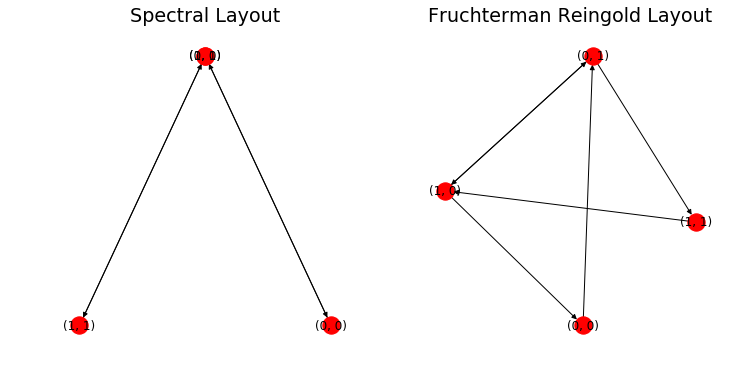

code length = 2  n_symbols = 3


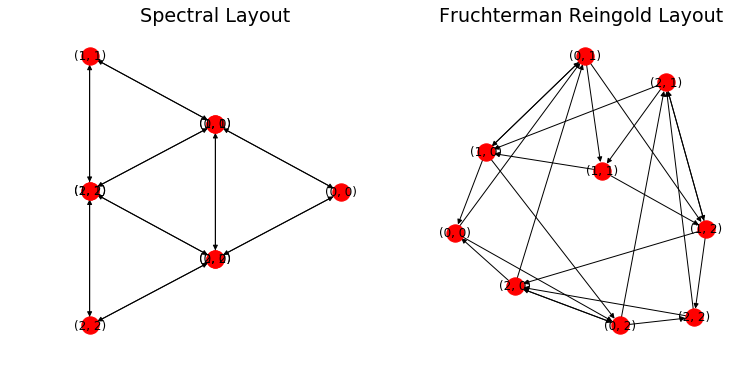

code length = 2  n_symbols = 4


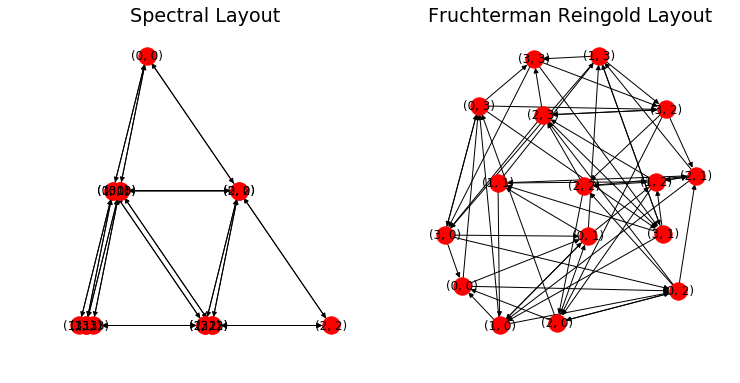

code length = 2  n_symbols = 5


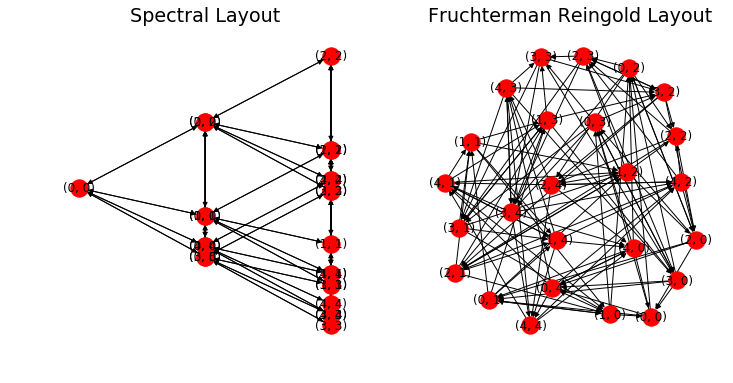

code length = 3  n_symbols = 2


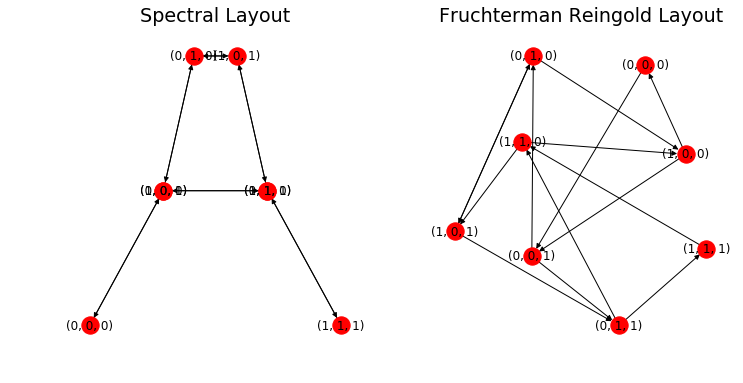

code length = 3  n_symbols = 3


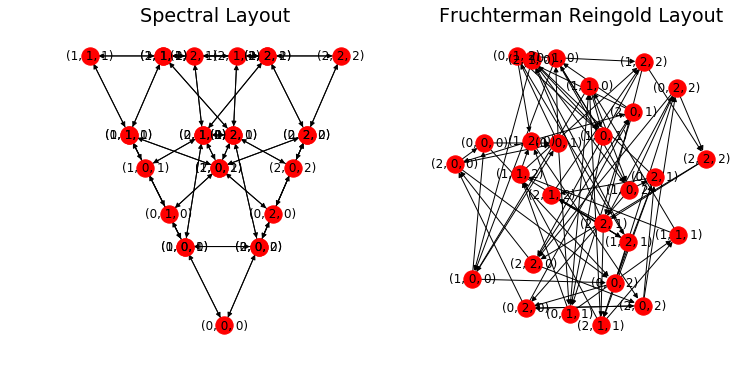

code length = 3  n_symbols = 4


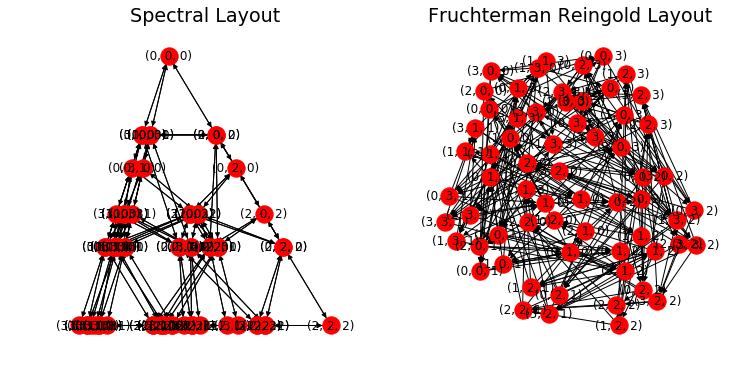

code length = 3  n_symbols = 5


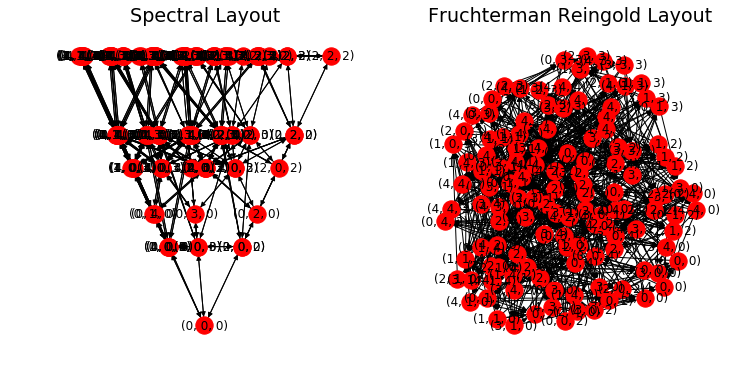

In [47]:
for code_length in range(2, 4):
    for n_symbols in [2, 3, 4, 5]:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        g = make_passcode_digraph(code_length, n_symbols)
        draw_graph(g, with_labels=True, ax=axes[0])
        draw_graph(g, with_labels=True, ax=axes[1], layout=nx.fruchterman_reingold_layout)
        axes[0].set_title("Spectral Layout")
        axes[1].set_title("Fruchterman Reingold Layout")
        print("code length = {}  n_symbols = {}".format(code_length, n_symbols))
        plt.show()

I find the spectral layouts for these graphs rather beautiful. I find the 3-3 graph particularly pretty. I have included the labels on all the graphs even though in most graphs the labels all run into each other making them mostly illegible. Unfortunately many nodes tend to get plotted exactly on top of each other in some of the representations, especially in the spectral layout for the smaller graphs.

It is interesting to note that nodes plotted at the corners of the triangles apparent in the spectral layout are the codes which consist entirely of repeated symbols. I'm betting this has something to do with the number of graph cycles these nodes participate in. 

## Tour Visualization

I also made a visualization of tours over nodes as a line plot overplotted on top of the graph adjacency matrix so that you can see how the space of possible codes gets explored.

In [66]:
def tour_adjacency_visualization(
    g,
    tour,
    node_order=None,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots()
    if node_order is None:
        node_order = list(g.nodes())
    
    n_nodes = len(node_order)
    node_to_index = {node:i for i, node in enumerate(node_order)}
    
    adj = nx.adjacency_matrix(g, nodelist=node_order)
    
    ax.imshow(adj.todense(), cmap="binary")
    ax.set_yticks(np.arange(n_nodes))
    ax.set_yticklabels([str(n) for n in node_order]);
    ax.set_xticks(np.arange(n_nodes))
    ax.set_xticklabels([str(n) for n in node_order], rotation="vertical");
    
    tour_node_indexes = [node_to_index[n] for n in tour]
    ax.plot(
        tour_node_indexes[1:], tour_node_indexes[:-1],
        c="orange",
        lw=3,
    )
    ax.scatter(
        tour_node_indexes[1:], tour_node_indexes[:-1],
        c="b",
        zorder=3,
    )

Here is a visualization for the 3-3 graph with an optimal tour over the nodes.

In [71]:
def find_optimal_tour(g, start_node=None, max_tries=100):
    tour = greedy_tour_search(g, start_node=start_node)
    tries = 0
    while len(tour) > len(g.nodes()):
        tour = greedy_tour_search(g, start_node=start_node)
        tries += 1
        if tries >= max_tries:
            break
    if len(tour) > len(g.nodes()):
        print("Warning: Failed to find an optimal tour")
    return tour

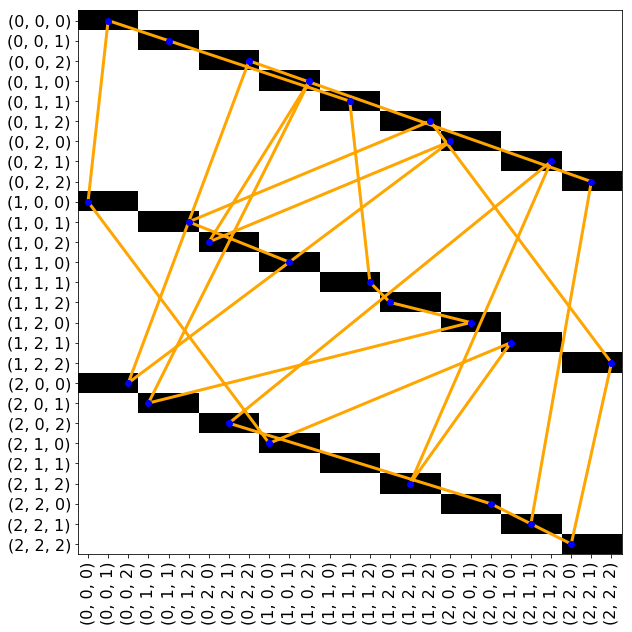

In [72]:
fig, ax = plt.subplots(figsize=(10, 10))
g33 = make_passcode_digraph(3, 3)

#find an optimal tour
tour = find_optimal_tour(g33)

tour_adjacency_visualization(g33, tour=tour, ax=ax)

We can reorder the rows and columns of the adjacency matrix as we like. If we order the adjacency matrix so that it is in the same order as the tour then the tour line will simply be a diagonal one above the main diagonal.

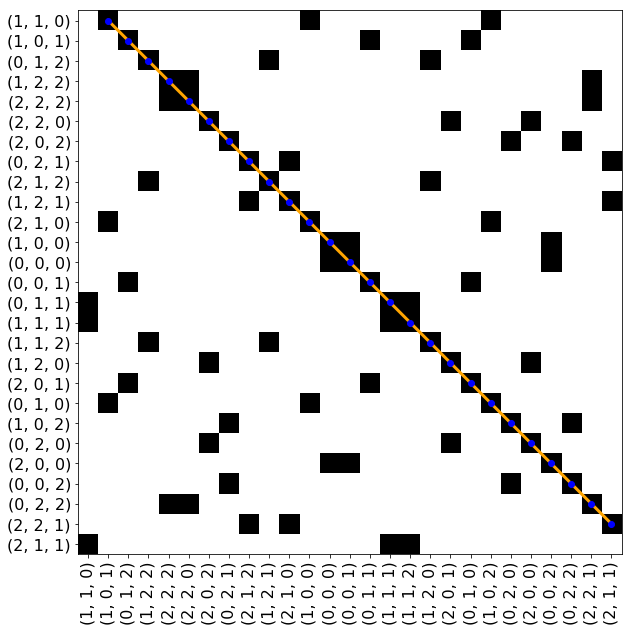

In [73]:
fig, ax = plt.subplots(figsize=(10, 10))
tour_adjacency_visualization(g33, tour=tour, ax=ax, node_order=tour)

It is clear that there are many possible shortest tours, even more than the simple n_symbols factorial different tours you would get from permutations of the base symbols. Here is the same tour as above but now with the adjacency matrix reordered using a different iteration of the greedy tour search.

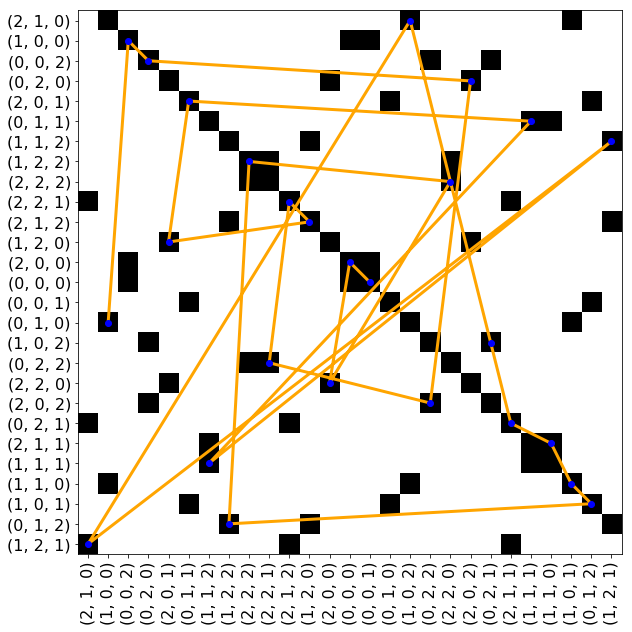

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))
tour_adjacency_visualization(g33, tour=tour, ax=ax, node_order=find_optimal_tour(g33))